```python
WARNING this is experimental and needs to be ran in the my_x86_env + complex_support branch!
```

In this notebook, we investigate a simple non-cartesian 2D example with deepinverse.

# 1. Building the operator

As we do not have all the fancy tools for non-cartesian MRI in deepinverse, we rely on the `mrinufft` package that comes with all the subtelties associated with this non-uniform FFT based problem.

## 1.1. Checking the backend

This first snippet is just here to check that dependencies are installed properly.

In [1]:
import matplotlib.pyplot as plt
from scipy.datasets import face # For demo
import numpy as np
import mrinufft
from mrinufft.trajectories import display

NufftOperator = mrinufft.get_operator("finufft")

## 1.2. Wrapping this in torch and deepinv

We next move to deepinv. We simply wrap the mrinufft operators within deepinv's LinearOperator class. As such, operations like grad and prox are available... 

In [2]:
import torch
from deepinv.physics import LinearPhysics
from mrinufft.density.geometry_based import voronoi

class Nufft(LinearPhysics):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    def __init__(
        self,
        img_size,
        samples_loc,
        density=None,
        real=False,
        **kwargs
    ):
        super(Nufft, self).__init__(**kwargs)
        
        self.real = real  # Whether to project the data on real images
        if density is not None:
            if density == 'voronoi':
                density = voronoi(samples_loc.reshape(-1, 2))
        
        self.nufft = NufftOperator(samples_loc.reshape(-1, 2), shape=img_size, density=density, n_coils=1, squeeze_dims=False)

    def A(self, x):
        return self.nufft.op(x)

    def A_adjoint(self, kspace):
        return self.nufft.adj_op(kspace)

# 2. An illustration

We now move to our 2D toy illustration.

In [3]:
from mrinufft import get_density, get_operator, check_backend
from mrinufft.trajectories import initialize_2D_radial
from mrinufft.io.nsp import read_trajectory
from mrinufft.trajectories.display import display_2D_trajectory
import matplotlib.pyplot as plt 
import numpy as np 

## 2.1 Trajectory

We here consider a standard SPARKLING trajectory.

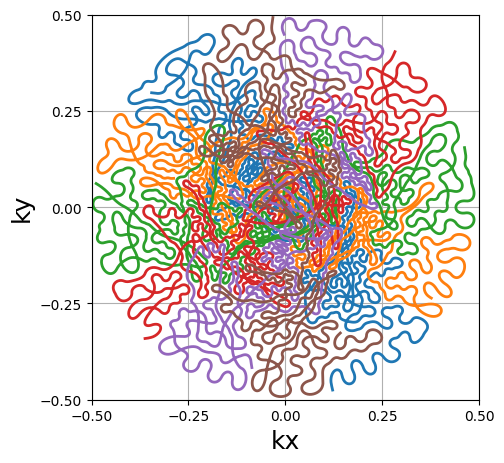

In [4]:
traj, params = read_trajectory("sparkling_2d")
traj *= 2   # The above trajectory is in [-0.25, 0.25] but we want it in [-0.5, 0.5]
display_2D_trajectory(traj)
traj = traj.astype(np.float32)

## 2.2 Groundtruth

The following data is our groundtruth.

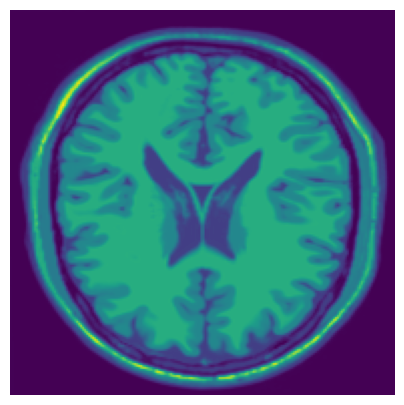

In [18]:
image = np.load('brainweb_2d_192.npy')
# image = np.load("brain_1.npy")

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis(False)
plt.show()

## 2.3 Generating the measurements

We now have all the tools to generate our measurements!

/volatile/BL/fastmri/lib/python3.10/site-packages/mrinufft/_utils.py:87: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(


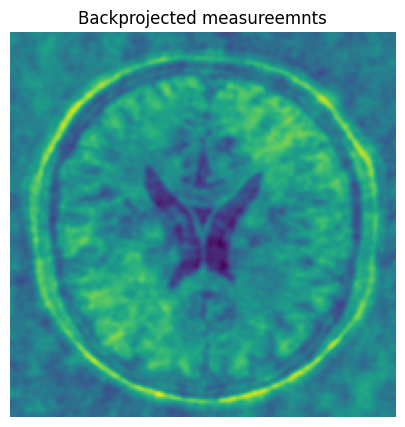

In [19]:
import torch

image_torch = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)
x = image_torch.clone()
x = x/x.abs().max()

# Create a 2D Radial trajectory
samples_loc = traj.copy()

# Generate the physics
physics = Nufft(image_torch[0, 0].shape, samples_loc, density=None)
y = physics.A(x)
back = physics.A_adjoint(y)

plt.figure(figsize=(10, 5))
plt.imshow(torch.real(back).squeeze())
plt.axis(False)
plt.title('Backprojected measureemnts')
plt.show()

## 2.4. Reconstruction algorithm

We next check that a standard reconstruction algorithm performs well. Here, we use the DPIR algorithm, which relies on a DRUNet.
Since the data is complex, we need to slightly adapt our denoiser and make it handle complex data. To do so, we'll simply denoise real and complex parts independently (we will batch both).
The following class adapts the denoiser.

In [14]:
class ComplexDenoiser(torch.nn.Module):
    def __init__(self, denoiser):
        super().__init__()
        self.denoiser = denoiser

    def forward(self, x, sigma):
        noisy_batch = torch.cat((x.real, x.imag), 0)
        denoised_batch = self.denoiser(noisy_batch, sigma)
        denoised = denoised_batch[0:1, ...]+1j*denoised_batch[1:2, ...]
        return denoised

We now have all the necessary tool to build our algorithm.

Algorithms in deepinv can be loaded very straightforwardly. In the snippet below, we keep things a bit more open-box to be able to play with parameters.

In [24]:
image_torch

tensor([[[[4.8008e-03, 5.1578e-03, 5.1682e-03,  ..., 8.5185e-04,
           1.3514e-03, 2.1119e-03],
          [2.6993e-03, 3.4085e-03, 3.1417e-03,  ..., 2.4018e-03,
           2.8987e-03, 2.6508e-03],
          [1.6266e-03, 2.2430e-03, 1.2418e-03,  ..., 1.1623e-03,
           2.5162e-03, 2.6998e-03],
          ...,
          [5.4073e-03, 5.8032e-03, 1.7413e-03,  ..., 2.6369e-04,
           0.0000e+00, 9.8154e-06],
          [5.7420e-03, 5.8712e-03, 1.7592e-03,  ..., 3.1183e-04,
           2.7607e-04, 2.3360e-04],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]]], dtype=torch.float64)

In [25]:
x.max()

tensor(1., dtype=torch.float64)

In [15]:
from deepinv.optim.data_fidelity import L2
from deepinv.optim import optim_builder, PnP
from deepinv.models import DRUNet

# Generate the physics
physics = Nufft(image_torch[0, 0].shape, samples_loc, density=None, real=False)
y = physics.A(x)
back = physics.A_adjoint(y)

# Load PnP denoiser backbone
model = DRUNet(in_channels=1, out_channels=1, pretrained='download')
model.eval()
model = ComplexDenoiser(model)


# Compute the sequence of parameters along iterates
def get_DPIR_params(noise_level_img, max_iter=8):
    r"""
    Default parameters for the DPIR Plug-and-Play algorithm.

    :param float noise_level_img: Noise level of the input image.
    """
    s1 = 49.0 / 255.0
    s2 = noise_level_img
    sigma_denoiser = np.logspace(np.log10(s1), np.log10(s2), max_iter).astype(
        np.float32
    )
    stepsize = (sigma_denoiser / max(0.01, noise_level_img)) ** 2
    lamb = 1 / 0.23
    return lamb, list(sigma_denoiser), list(stepsize), max_iter


# Set the DPIR algorithm parameters
sigma = 0.01  # Noise level in the image domain
max_iter = 8  # Max number of iterations
lamb, sigma_denoiser, stepsize, max_iter = get_DPIR_params(sigma, max_iter=max_iter)
params_algo = {"stepsize": stepsize, "g_param": sigma_denoiser, "lambda": lamb}
early_stop = False  # Do not stop algorithm with convergence criteria

# Select the data fidelity term
data_fidelity = L2()

# Specify the denoising prior
prior = PnP(denoiser=model)

# instantiate the algorithm class to solve the IP problem.
algo = optim_builder(
    iteration="HQS",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=True,
    params_algo=params_algo,
)


/volatile/BL/fastmri/lib/python3.10/site-packages/mrinufft/_utils.py:87: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(


Now, let's reconstruct! 

The following snippet runs the algorithm.

In [16]:
with torch.no_grad():
    x_hat = algo(y, physics)

Next, we compute metric and plot reconstruction.

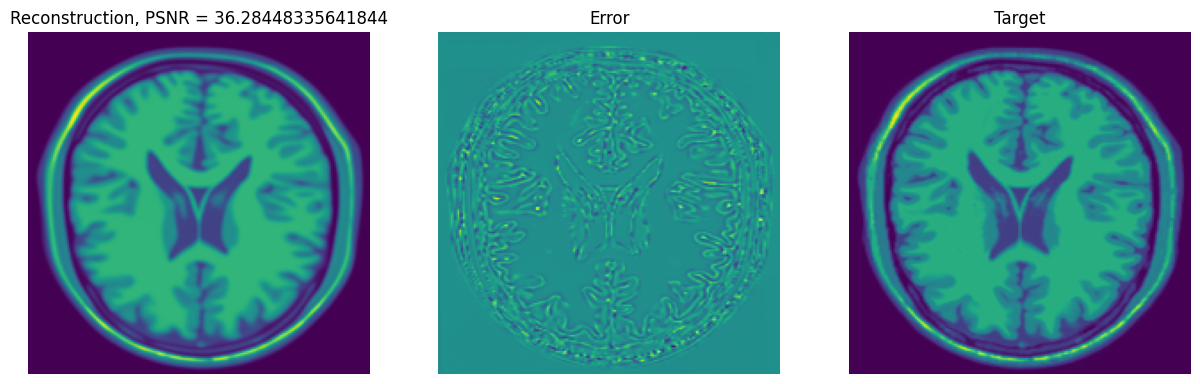

In [10]:
from deepinv.utils.metric import cal_psnr

# Compute reconstruction metric
psnr = cal_psnr(x.abs(), x_hat.abs()).item()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(np.real(x_hat).squeeze(), cmap='viridis')
plt.title('Reconstruction, PSNR = ' + str(psnr))
plt.axis('off')
plt.subplot(132)
plt.imshow(np.real(x_hat-x).squeeze(), cmap='viridis')
plt.title('Error')
plt.axis('off')
plt.subplot(133)
plt.imshow(np.real(x).squeeze(), cmap='viridis')
plt.title('Target')
plt.axis('off')
plt.show()

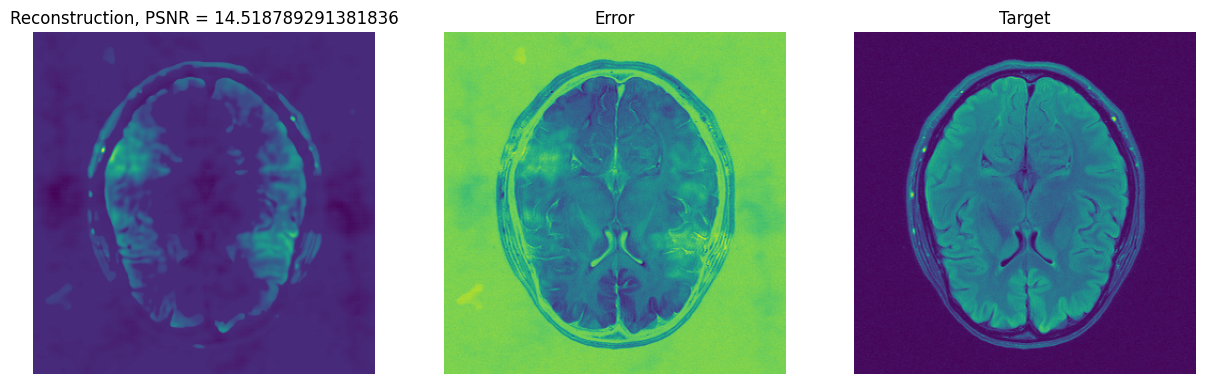

In [17]:
from deepinv.utils.metric import cal_psnr

# Compute reconstruction metric
psnr = cal_psnr(x.abs(), x_hat.abs()).item()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(np.real(x_hat).squeeze(), cmap='viridis')
plt.title('Reconstruction, PSNR = ' + str(psnr))
plt.axis('off')
plt.subplot(132)
plt.imshow(np.real(x_hat-x).squeeze(), cmap='viridis')
plt.title('Error')
plt.axis('off')
plt.subplot(133)
plt.imshow(np.real(x).squeeze(), cmap='viridis')
plt.title('Target')
plt.axis('off')
plt.show()

## 2.5 The case of FISTA+wavelets

We can consider a simpler reconstruction algorithm. For example, the FISTA algorithm with a wavelet prior is a good choice.

The next snippet proposes an implementation of FISTA from scratch.

In [11]:
from deepinv.models import WaveletDictDenoiser

physics = Nufft(image_torch[0, 0].shape, samples_loc, density=None, real=False)

x = image_torch.clone()
x = x/x.abs().max()
y = physics.A(x)
back = physics.A_adjoint(y)

# Let's implement a FISTA version
data_fidelity = L2()

a = 3

sigma = 0.01
stepsize = 0.1


# Select a prior
wav = WaveletDictDenoiser(non_linearity="soft", level=5, list_wv=['db8'], max_iter=10)
device = 'cpu'
denoiser = ComplexDenoiser(wav).to(device)

max_iter = 100

# Initialize algo variables
x_cur = back.clone().to(device)
w = back.clone().to(device)
u = back.clone().to(device)

# FISTA iteration
for k in range(max_iter):

    tk = (k+a-1)/a
    tk_ = (k+a)/a

    x_prev = x_cur.clone()

    x_cur = w - stepsize*data_fidelity.grad(w, y, physics)
    x_cur = denoiser(x_cur, sigma*stepsize)

    w = (1-1/tk)*x_cur+1/tk*u

    u = x_prev+tk*(x_cur-x_prev)

    crit = torch.linalg.norm(x_cur.flatten()-x_prev.flatten())
    
    if k%10 == 0:
        print('Iteration ', k, '\t criterion = ', crit)

x_hat = x_cur.clone()

/volatile/BL/fastmri/lib/python3.10/site-packages/mrinufft/_utils.py:87: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(


ImportError: pytorch_wavelets is needed to use the WaveletDenoiser class. It should be installed with `pip install ptwt`.

In [ ]:
psnr = cal_psnr(x.abs(), x_hat.abs()).item()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(np.real(x_hat).squeeze(), cmap='viridis')
plt.title('Reconstruction, PSNR = ' + str(psnr))
plt.axis('off')
plt.subplot(132)
plt.imshow(np.real(x_hat-image_torch).squeeze(), cmap='viridis')
plt.title('Error')
plt.axis('off')
plt.subplot(133)
plt.imshow(np.real(image_torch).squeeze(), cmap='viridis')
plt.title('Target')
plt.axis('off')
plt.show()